In [1]:
import os
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import shutil
import sys
import tensorflow as tf

from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm

2023-10-07 05:20:47.033560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 05:20:47.205823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 05:20:47.205856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 05:20:47.207195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 05:20:47.296900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 05:20:47.298128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Constants

In [2]:
SCAN_GROUP = "MPRAGE"
MRI_DATA_PATH = "data/MPRAGE_data"
LABEL_DATA_PATH = "data/AD_time_to_dx.csv"

TRAIN_DATA_PATH = "data/train"
VAL_DATA_PATH = "data/val"

NUM_EPOCHS = 10
NUM_PATIENTS_PER_GROUP = 25
NUM_PATIENTS = NUM_PATIENTS_PER_GROUP*2
IMG_SHAPE = (256,256)

# Important Functions

In [3]:
def get_file_list(directory) -> list:
    return os.listdir(directory)

def unique_items_in_list(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    
    return unique_list

def convert_3d_to_2d(array_3d):
    return np.reshape(array_3d, (array_3d.shape[0], array_3d.shape[1]*array_3d.shape[2]))

def resize_array(val, image_size=(256,256)):
    # Do not resize arrays of the correct size
    if val.shape == image_size:
        return val
    
    # Resize image arrays with Bilinear Interpolation
    image = Image.fromarray(val, mode='L')
    resized_image = image.resize(image_size, Image.BILINEAR)
    #resized_array = np.expand_dims(np.array(resized_image), axis=-1) # TF expects channels dim
    resized_array = np.array(resized_image)
    return resized_array


def copy_file_to_dir(filename, src_dir, dest_dir):
    # Create directory ifit doesn't exist
    if not os.path.isdir(dest_dir):
        os.mkdir(dest_dir)

    src_path = src_dir + "/" + filename
    dest_path = dest_dir + "/" + filename

    try:
        os.path.isfile(dest_path) 
    except FileNotFoundError:
        # doesn't exist
        shutil.copy(src_path, dest_path)
    else:
        # exists
        pass
        

# Check out Unique Patients in the AD_time_to_dx.csv file

In [4]:
df_labels = pd.read_csv(LABEL_DATA_PATH)

full_patients_list = df_labels["PTID"].values

print(f"Number of patients in AD_time_to_dx.csv: {len(unique_items_in_list(full_patients_list))}\n\n")

print(f"List of {len(unique_items_in_list(full_patients_list))} Patients:\n")
print(*full_patients_list, sep=", ")

Number of patients in AD_time_to_dx.csv: 495


List of 495 Patients:

022_S_0004, 011_S_0005, 100_S_0006, 022_S_0014, 100_S_0015, 011_S_0016, 067_S_0019, 011_S_0021, 011_S_0022, 011_S_0023, 023_S_0030, 023_S_0031, 035_S_0033, 100_S_0035, 067_S_0038, 099_S_0040, 007_S_0041, 023_S_0042, 018_S_0043, 100_S_0047, 035_S_0048, 123_S_0050, 099_S_0051, 099_S_0054, 067_S_0056, 018_S_0057, 023_S_0058, 067_S_0059, 099_S_0060, 023_S_0061, 022_S_0066, 010_S_0067, 007_S_0068, 100_S_0069, 007_S_0070, 123_S_0072, 027_S_0074, 067_S_0077, 018_S_0080, 023_S_0081, 136_S_0086, 018_S_0087, 073_S_0089, 099_S_0090, 032_S_0095, 022_S_0096, 020_S_0097, 067_S_0098, 007_S_0101, 123_S_0106, 136_S_0107, 123_S_0108, 099_S_0111, 127_S_0112, 123_S_0113, 027_S_0116, 027_S_0118, 027_S_0120, 131_S_0123, 041_S_0125, 023_S_0126, 068_S_0127, 007_S_0128, 022_S_0130, 021_S_0141, 018_S_0142, 037_S_0150, 018_S_0155, 035_S_0156, 137_S_0158, 021_S_0159, 098_S_0160, 114_S_0166, 011_S_0168, 014_S_0169, 098_S_0171, 098_S_0172, 114_S_

# Script to get patient ids and scan dates

### After downloading the meta data of all MRI scans of all patient in the AD_time_to_dx.csv file, this script explores the most common types of scans and their dates

In [5]:
df = None

# dictionary with list object in values
df_dict = {
    'patient_id' : [],
    'group' : [],
    'scan_date' : []
}

full_patient_ids = get_file_list(MRI_DATA_PATH)

for i in tqdm(range(len(full_patient_ids))):
    pid = full_patient_ids[i]
    GROUP_DIR_PATH = MRI_DATA_PATH + "/" + pid

    # Ignore non-directory metadata at this level
    if not os.path.isdir(GROUP_DIR_PATH):
        continue

    group_list = get_file_list(GROUP_DIR_PATH)

    for group in group_list:
        DATE_PATH = GROUP_DIR_PATH + "/" + group
            
        date_list = get_file_list(DATE_PATH)
    
        for date in date_list:
            df_dict["patient_id"].append(pid)
            df_dict["group"].append(group)
            df_dict["scan_date"].append(date)
            

# creating a Dataframe object 
df = pd.DataFrame(df_dict)

df.to_csv("data/adni_patient_scan_dates.csv")

print(df.head())

print(f"\n\nNumber of distinct patients in metadata = {len(df.patient_id.unique())}\n")

df_groups = df.groupby('group')

# For debugging purposes
sorted_df_groups = df.group.unique()
sorted_df_groups.sort()

print("Number of unique patients per scan group:")
print(df_groups['patient_id'].nunique().sort_values(ascending=False), end="\n\n")

mprage_patient_list = df_groups.get_group(SCAN_GROUP)['patient_id'].unique()

print("Patient IDs with " + SCAN_GROUP + " scans:\n")
print(mprage_patient_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:01<00:00, 237.09it/s]

   patient_id   group              scan_date
0  002_S_0295  MPRAGE  2011-06-02_07_58_50.0
1  002_S_0295  MPRAGE  2012-05-10_15_44_50.0
2  002_S_0413  MPRAGE  2006-11-15_14_23_26.0
3  002_S_0413  MPRAGE  2006-11-15_14_34_44.0
4  002_S_0413  MPRAGE  2007-06-01_07_57_43.0


Number of distinct patients in metadata = 311

Number of unique patients per scan group:
group
MPRAGE    311
Name: patient_id, dtype: int64

Patient IDs with MPRAGE scans:

['002_S_0295' '002_S_0413' '002_S_0685' '002_S_0729' '002_S_0954'
 '002_S_1070' '002_S_1155' '002_S_1261' '002_S_1268' '002_S_1280'
 '003_S_0907' '003_S_0908' '003_S_0981' '003_S_1057' '003_S_1122'
 '006_S_0498' '006_S_0731' '009_S_0751' '009_S_0842' '009_S_1030'
 '010_S_0067' '010_S_0419' '010_S_0422' '010_S_0472' '010_S_0904'
 '011_S_0005' '011_S_0016' '011_S_0021' '011_S_0022' '011_S_0023'
 '011_S_0168' '011_S_0241' '011_S_0326' '011_S_0362' '011_S_0856'
 '011_S_0861' '011_S_1080' '011_S_1282' '012_S_0634' '012_S_0637'
 '012_S_0932' '012_S_1009' 

#### It seems that among the 495 patients in the list, MPRAGE is the most common type of scan that they have (311 out of 495 patients)

AD_dx_in_5_yrs
0    218
1     93
Name: count, dtype: int64


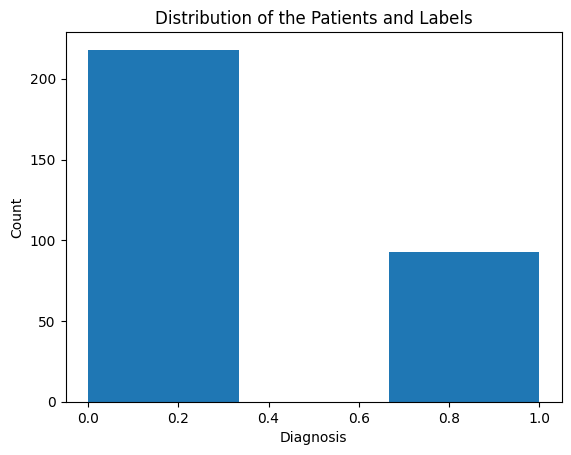

In [6]:
df_mprage_labels = df_labels[df_labels['PTID'].isin(mprage_patient_list)]

diagnosis_value_counts = df_mprage_labels['AD_dx_in_5_yrs'].value_counts()

print(diagnosis_value_counts)

plt.hist(df_mprage_labels['AD_dx_in_5_yrs'], bins=3)
plt.title('Distribution of the Patients and Labels')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

## Sample the Amount of Patients for an even split between 0 and 1

### Because my RAM can't handle the entire dataset (get first `NUM_PATIENTS_PER_GROUP` patients of each group)

In [7]:
patients_AD_dx_in_5_yrs_0_list = df_mprage_labels[df_mprage_labels['AD_dx_in_5_yrs'] == 0]['PTID'].unique()[0:NUM_PATIENTS_PER_GROUP]
patients_AD_dx_in_5_yrs_1_list = df_mprage_labels[df_mprage_labels['AD_dx_in_5_yrs'] == 1]['PTID'].unique()[0:NUM_PATIENTS_PER_GROUP]
filtered_patients_list = np.concatenate((patients_AD_dx_in_5_yrs_0_list, patients_AD_dx_in_5_yrs_1_list), axis=0)

print(f"{len(patients_AD_dx_in_5_yrs_0_list)} patients with 0 value\n{len(patients_AD_dx_in_5_yrs_1_list)} patients with 1 value")

25 patients with 0 value
25 patients with 1 value


# Test Generating MRI Data Array for MPRAGE Scans

## Get Maximum number of images of a patient has in an MPRAGE Scan and show the distribution

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 527.39it/s]


Number of patients: 50

Most number of images in an MP-RAGE scan: 184

Least number of images in an MP-RAGE scan: 160



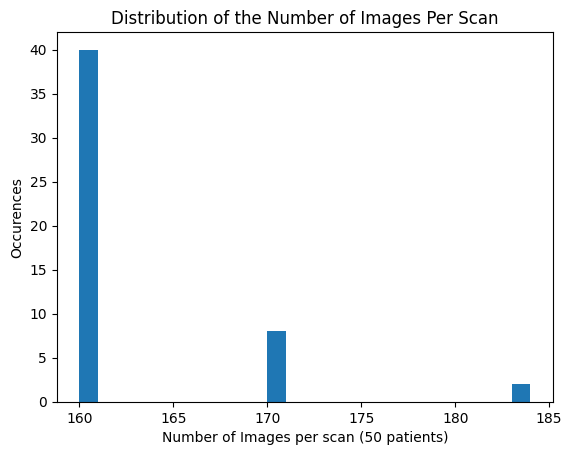

In [8]:
patient_list = get_file_list(MRI_DATA_PATH)

list_of_image_quantities = list()

for i in tqdm(range(len(patient_list))):
    patient_id = patient_list[i]

    # temporarily limit amount of data
    if patient_id not in filtered_patients_list:
        continue
    
    PATIENT_ID_PATH = MRI_DATA_PATH + "/" + patient_id
    
    scan_list = get_file_list(PATIENT_ID_PATH)

    is_group_scanned = False
    
    for scan_group in scan_list:
        
        # Scan first group only
        if is_group_scanned:
            continue
            
        if scan_group != SCAN_GROUP:
            continue
        else:
            is_group_scanned = True
            
            array_list = list()

            SCAN_PATH = PATIENT_ID_PATH + "/" + scan_group

            date_list = get_file_list(SCAN_PATH)

            date_list.sort()
            
            is_date_scanned = False
            
            for date in date_list:

                # Use the first date only
                if is_date_scanned:
                    continue

                is_date_scanned = True
                
                DATE_PATH = SCAN_PATH + "/" + date

                id_list = get_file_list(DATE_PATH)

                is_id_scanned = False
                
                for id in id_list:

                    # Scan first ID only
                    if is_id_scanned:
                        continue
            
                    is_id_scanned = True
                    
                    ID_PATH = DATE_PATH + "/" + id
                
                    file_list = get_file_list(ID_PATH)

                    list_of_image_quantities.append(len(file_list))

max_images = max(list_of_image_quantities) # Use this variable in the next step
min_images = min(list_of_image_quantities)

print(f"Number of patients: {len(list_of_image_quantities)}\n")
print(f"Most number of images in an MP-RAGE scan: {max_images}\n")
print(f"Least number of images in an MP-RAGE scan: {min_images}\n")

plt.hist(list_of_image_quantities, bins=(max_images-min_images))
plt.title('Distribution of the Number of Images Per Scan')
plt.xlabel(f'Number of Images per scan ({len(list_of_image_quantities)} patients)')
plt.ylabel('Occurences')
plt.show()

## Build Data and Label Arrays

### The Data array is a 3D array that is a list of 256 x 256 pixel arrays (N x 256 x 256)
### The Label array is a 2D array that is a list of single-digit labels (N x 1)

In [9]:
# Create look-up dictionary for labels {"patient_id" : "AD_dx_in_5_yrs"}
patient_label_dict = df_labels[['PTID','AD_dx_in_5_yrs']].set_index('PTID').to_dict()['AD_dx_in_5_yrs']

patient_list = get_file_list(MRI_DATA_PATH)

# Carriers for data to be turned into arrays
data_list = list()
label_list = list()

for i in tqdm(range(len(patient_list))):
    
    patient_id = patient_list[i]
    
    # temporarily limit amount of data
    if patient_id not in filtered_patients_list:
        continue
    
    PATIENT_ID_PATH = MRI_DATA_PATH + "/" + patient_id
    
    scan_list = get_file_list(PATIENT_ID_PATH)
    
    is_group_scanned = False
    
    for scan_group in scan_list:

        # Scan first group only
        if is_group_scanned:
            continue
        
        if scan_group != SCAN_GROUP:
            continue
        else:
            is_group_scanned = True

            SCAN_PATH = PATIENT_ID_PATH + "/" + scan_group

            date_list = get_file_list(SCAN_PATH)

            date_list.sort()
            
            is_date_scanned = False
            
            for date in date_list:

                # Use the first date only
                if is_date_scanned:
                    continue
                is_date_scanned = True
                
                DATE_PATH = SCAN_PATH + "/" + date

                id_list = get_file_list(DATE_PATH)

                is_id_scanned = False
                
                for id in id_list:

                    # Scan first ID only
                    if is_id_scanned:
                        continue
            
                    is_id_scanned = True
                    
                    ID_PATH = DATE_PATH + "/" + id
                
                    file_list = get_file_list(ID_PATH)
                    
                    for file_name in file_list:
                        np.set_printoptions()
                        file_path = ID_PATH + "/" + file_name
        
                        # Convert DCM file to pixel array
                        dcm = pydicom.dcmread(file_path)
                        pixel_array = dcm.pixel_array

                        # Resize to (256, 256)
                        # if pixel_array.shape != IMG_SHAPE:
                        #     pixel_array = np.resize(pixel_array, IMG_SHAPE)

                        # Resize to (256, 256)
                        pixel_array = resize_array(val=pixel_array, image_size=IMG_SHAPE)
                        
                        # Scale pixel array
                        ## Step 1. Convert to float to avoid overflow or underflow losses.
                        pixel_array = pixel_array.astype(float)

                        ## Step 2. Rescaling grey scale between 0-255
                        pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
                        
                        ## Step 3. Convert to uint
                        pixel_array = np.uint8(pixel_array)
                        
                        data_list.append(pixel_array)
                        label_list.append(patient_label_dict[patient_id])

data_array = np.array(data_list)
label_array = np.array(label_list)
print("Data Array Shape" + str(data_array.shape))
print("Data Array Size: %d bytes" % (data_array. size * data_array. itemsize))
print("Data Array Size: %d MiB" % (data_array. size * data_array. itemsize / 1048576 ))
print("Data Array Size: %d GiB" % (data_array. size * data_array. itemsize / 1073741824))

# Free up memory
del data_list
del label_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [01:32<00:00,  3.38it/s]

Data Array Shape(8128, 256, 256)
Data Array Size: 532676608 bytes
Data Array Size: 508 MiB
Data Array Size: 0 GiB


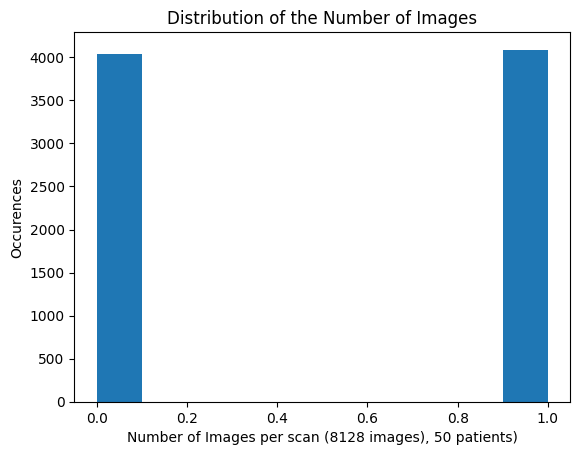

In [10]:
plt.hist(label_array)
plt.title('Distribution of the Number of Images')
plt.xlabel(f'Number of Images per scan ({len(label_array)} images), {NUM_PATIENTS} patients)')
plt.ylabel('Occurences')
plt.show()

# Train Test Split (80:20)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_array, label_array,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True,
                                   stratify=label_array
                                  )

# Build Model

### Copy-pasted from the "classification_notebook.ipynb"  notebook

In [12]:

# Assuming your grayscale images have a shape of (1288, 256, 256)
input_shape = (256, 256, 3)  # Assuming 256x256 RGB images

# Add RGB Channel to Grayscaled Input
print(f"Training data shape before adding RGB: {X_train.shape}")
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, -1)
print(f"Training data shape after adding RGB: {X_train_rgb.shape}")

# Preprocess input
X_rgb = preprocess_input(X_train_rgb, data_format=None)
X_test_rgb = preprocess_input(X_test_rgb, data_format=None)

# Instantiate base model from ResNet50 and exclude head
base_model = ResNet50(include_top=False, input_shape=input_shape, weights="imagenet")

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False
    
# Customize the model by adding Dense layers
input_tensor = Input(shape=input_shape)
resized_input = Resizing(256, 256)(input_tensor)
base_model_output = base_model(resized_input)
flatten_output = Flatten()(base_model_output)

# Original Layer
dense_output_1 = Dense(512, activation="relu")(flatten_output)
dropout_output_1 = Dropout(0.3)(dense_output_1)
normalized_output_1 = BatchNormalization()(dropout_output_1)

# Additional layer
# dense_output_2 = Dense(256, activation="relu")(normalized_output_1)
# dropout_output_2 = Dropout(0.3)(dense_output_2)
# normalized_output_2 = BatchNormalization()(dropout_output_2)

# Additional layer
# dense_output_3 = Dense(128, activation="relu")(normalized_output_2)
# dropout_output_3 = Dropout(0.3)(dense_output_3)
# normalized_output_3 = BatchNormalization()(dropout_output_3)

# dense_output_4 = Dense(64, activation="relu")(normalized_output_3)
# dropout_output_4 = Dropout(0.3)(dense_output_4)
# normalized_output_4 = BatchNormalization()(dropout_output_4)
# ... add more layers as needed

# Final output layer (use two inner layers on top of base model)
output_tensor = Dense(1, activation="sigmoid")(normalized_output_1) # activation="softmax"
# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=["accuracy"])

# Print model summary
model.summary()

Training data shape before adding RGB: (6502, 256, 256)
Training data shape after adding RGB: (6502, 256, 256, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
             

# Train ResNet50 Model

In [13]:
history = model.fit(X_rgb, y_train,
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_test_rgb, y_test))


Epoch 1/10


2023-10-07 05:22:35.561093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5113380864 exceeds 10% of free system memory.


204/204 [==============================] - 383s 2s/step - loss: 0.5093 - accuracy: 0.7350 - val_loss: 0.3547 - val_accuracy: 0.8167
Epoch 2/10
204/204 [==============================] - 375s 2s/step - loss: 0.3182 - accuracy: 0.8507 - val_loss: 0.3044 - val_accuracy: 0.8622
Epoch 3/10
204/204 [==============================] - 403s 2s/step - loss: 0.2572 - accuracy: 0.8876 - val_loss: 0.2959 - val_accuracy: 0.8739
Epoch 4/10
204/204 [==============================] - 378s 2s/step - loss: 0.2168 - accuracy: 0.9033 - val_loss: 0.2369 - val_accuracy: 0.8918
Epoch 5/10
204/204 [==============================] - 379s 2s/step - loss: 0.2011 - accuracy: 0.9140 - val_loss: 0.3343 - val_accuracy: 0.8198
Epoch 6/10
204/204 [==============================] - 383s 2s/step - loss: 0.1941 - accuracy: 0.9196 - val_loss: 0.2410 - val_accuracy: 0.8868
Epoch 7/10
204/204 [==============================] - 373s 2s/step - loss: 0.2034 - accuracy: 0.9096 - val_loss: 0.2200 - val_accuracy: 0.9084
Epoch 8/10

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048  

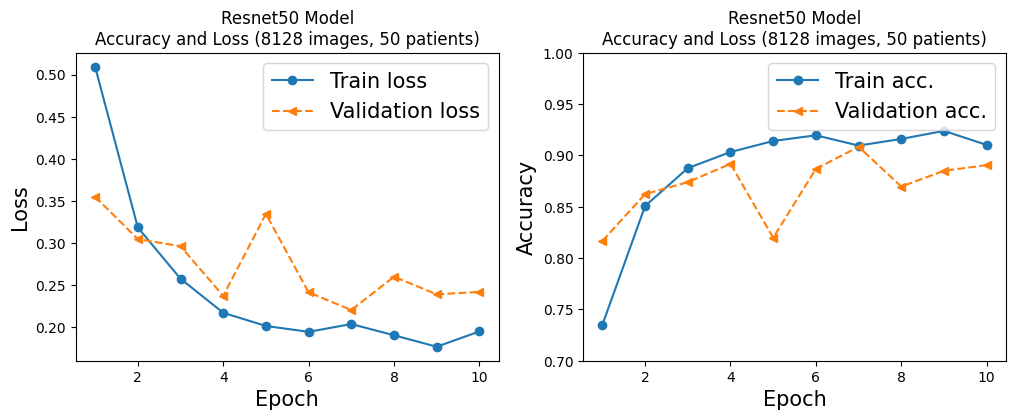

In [15]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_title(f"Resnet50 Model\nAccuracy and Loss ({len(label_array)} images, {NUM_PATIENTS} patients)")

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0.7,1)
ax.set_title(f"Resnet50 Model\nAccuracy and Loss ({len(label_array)} images, {NUM_PATIENTS} patients)")
plt.show()

# Compare with Original Model

In [16]:
model_old = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(65536, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_old.summary()

model_old.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
              # ^ because our last layer does not apply sigmoid, by specifying from logits=True, the loss function applies the sigmoid function internally
              # ^ it's more efficient than doing it manually
              metrics=['accuracy']) # you can add other metrics here

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16777472  
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16810497 (64.13 MB)
Trainable params: 16810497 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
X_train_2d = convert_3d_to_2d(X_train)
X_test_2d = convert_3d_to_2d(X_test)
print(f"Training data shape before scaling: {X_train.shape}")

# Add scaling
scaler = MinMaxScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)
print(f"Training data shape after scaling: {X_train.shape}")

Training data shape before scaling: (6502, 256, 256)
Training data shape after scaling: (6502, 256, 256)


In [ ]:
history_old = model_old.fit(X_train_2d, y_train,
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_test_2d, y_test))

In [ ]:
hist = history_old.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_title(f"Old Model\nAccuracy and Loss ({len(label_array)} images, {NUM_PATIENTS} patients)")

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0.7,1)
ax.set_title(f"Old Model\nAccuracy and Loss ({len(label_array)} images, {NUM_PATIENTS} patients)")
plt.show()